### HW_3
1) Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2) Подберите параметры модели SARIMAX для этого ряда.

3) Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4) Возмите вариант 1 или 2

Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)   
Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv тут можно скачать актуальные данные.    
5) Оцените результат моделирования

#### Ответ

1) Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_m = data.resample('M').mean()

In [3]:
data_m.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,32108.628796,2009.84000,6.420000,15.645434,2.475000,179.905434,26.140008,2.996992,11.499990,0.027135,0.026964,0.027152
std,3534.668371,4.82606,3.444258,1.084200,1.116066,104.903962,14.634509,0.115045,0.017667,0.022668,0.022522,0.022681
min,26314.458333,2002.00000,1.000000,1.530612,1.000000,16.000000,2.741935,2.530612,11.265306,0.000000,0.000000,0.000000
25%,29193.559812,2006.00000,3.000000,15.500000,1.000000,76.008748,11.702145,2.903226,11.500000,0.000000,0.000000,0.000000
50%,31879.175067,2010.00000,6.000000,16.000000,2.000000,167.500000,24.666667,3.000000,11.500000,0.032258,0.032258,0.032258
75%,34574.729839,2014.00000,9.000000,16.000000,3.000000,259.500000,37.800000,3.095967,11.500000,0.033621,0.033333,0.033621
max,40603.403226,2018.00000,12.000000,16.020188,4.000000,351.000000,51.000000,3.193548,11.515478,0.066759,0.066759,0.066759


---------------------------------------------------------------------------------------------------------------

2) Подберите параметры модели SARIMAX для этого ряда

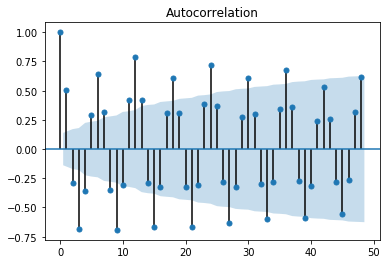

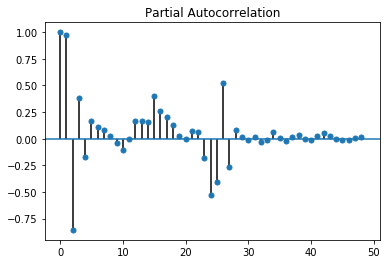

In [4]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=48)
plt.show()

sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=48)
plt.show()

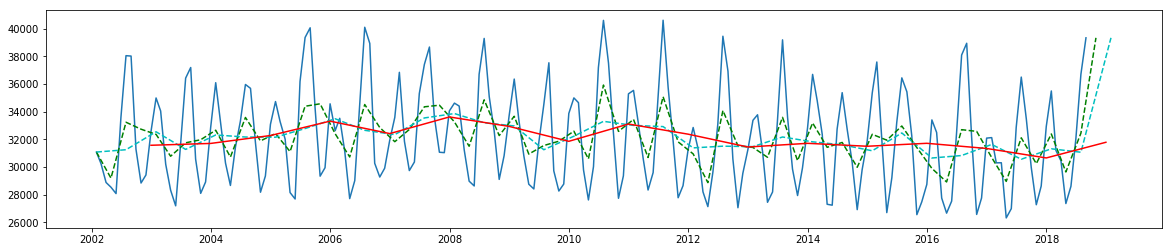

In [5]:
data_3m = data.resample('3M').mean()
data_6m = data.resample('6M').mean()
data_y = data.resample('Y').mean()

plt.figure(figsize =(20,4))
plt.plot(data_m.index, data_m['PJME_MW'].values)
plt.plot(data_3m.index, data_3m['PJME_MW'].values, '--g')
plt.plot(data_6m.index, data_6m['PJME_MW'].values, '--c')
plt.plot(data_y.index, data_y['PJME_MW'].values, 'r')

In [6]:
q = range(0, 25, 3)
p = range(0, 25, 3)
d = [0, 1, 2]

pdq = list(itertools.product(p, d, q))

qs = [0, 1, 2]
ps = [0, 1] 
ds = [0, 1]

seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(ps, ds, qs))]

In [7]:
min_aic = np.inf
best_param = (0, 0, 0)
best_param_seasonal = (0, 0, 0, 6)

params_result = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])
i = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-20],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = model.fit()
            params_result.loc[i, 'param'] = param
            params_result.loc[i, 'param_seasonal'] = param_seasonal
            params_result.loc[i, 'aic'] = results.aic
            i +=1
            if results.aic < min_aic:
                min_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal            
        except:
            continue
            
print(f'Best SARIMA parameters: {best_param}x{best_param_seasonal} with min AIC = {min_aic}')

Best SARIMA parameters: (12, 2, 24)x(0, 1, 0, 6) with min AIC = 2611.6357605098383


In [8]:
best_model = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-20],
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)


results_opt = best_model.fit()

print(f'AIC: {results_opt.aic}')

AIC: 2611.6357605098383


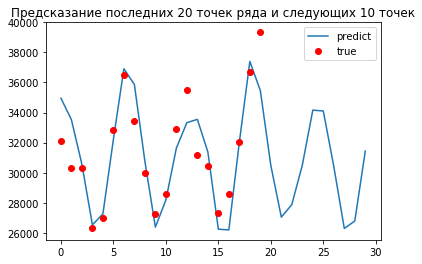

In [9]:
pred_dynamic = results_opt.forecast(30)   

plt.plot(pred_dynamic, label='predict')
plt.plot(data_m['PJME_MW'].values[-20:], 'or', label='true')
plt.title('Предсказание последних 20 точек ряда и следующих 10 точек')
plt.legend()

plt.show()

---------------------------------------------------------------------------------------------------------------

3) Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Лучшие результаты на недельных данных параметры модели ARIMA(0, 1, 2)x(0, 1, 2, 26) - AIC: 8327.5 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

Лучшие результаты на данных помесячно SARIMA: (12, 2, 24)x(0, 1, 0, 6) c AIC = 2611.6

##### На помесячных данных для модели SARIMA оптимальными оказались параметры (в сравнении с оптимальными для модели на недельных данных):  
Глубина регрессии p = 12 месяцев, было 0 (но при этом выбор ранее производился из диапазона [0,1,2])   
Порядок интегрированного ряда d = 2, было 1  
Длина скользящего среднего q = 24 месяца, было 2 недели    
С тем же сезоном (6 месяцев = 26 недель)   
P остался равым 0,  
D остался равным 1,  
Q = 0, было 2 недели  
То есть наиболее продуктивно (с наименьшей ошибкой) предсказывает авторегрессия с глубиной в 12 месяцев и сглаживанием в 24 месяца, что сильно отличается от параметров при понедельном ресемплинге, но может объясняться тем, что выбор ранее производился из диапазона [0,1,2].    
Сезонные параметры остались практически теми же, если учесть, что 2-недельное сглаживание и модель на месячных данных без сглаживания достаточно близки друг к другу. 

In [10]:
print(results_opt.summary().tables[0], results_opt.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(12, 2, 24)x(0, 1, [], 6)   Log Likelihood               -1268.818
Date:                              Wed, 13 May 2020   AIC                           2611.636
Time:                                      09:14:31   BIC                           2722.282
Sample:                                           0   HQIC                          2656.592
                                              - 180                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

---------------------------------------------------------------------------------------------------------------

4) Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv тут можно скачать актуальные данные.

In [11]:
Covid_19 = 'covid_19_data.csv'
df = pd.read_csv(Covid_19, index_col=[0], parse_dates=[0])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21866 entries, 1 to 21866
Data columns (total 7 columns):
ObservationDate    21866 non-null object
Province/State     10586 non-null object
Country/Region     21866 non-null object
Last Update        21866 non-null object
Confirmed          21866 non-null float64
Deaths             21866 non-null float64
Recovered          21866 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.3+ MB


In [13]:
df.drop('Province/State', axis=1, inplace=True)

In [14]:
df['Country/Region'].value_counts()

US                 4178
Mainland China     3253
Canada              889
Australia           676
France              598
                   ... 
St. Martin            1
North Ireland         1
East Timor            1
Channel Islands       1
('St. Martin',)       1
Name: Country/Region, Length: 222, dtype: int64

In [15]:
df_us = df.loc[df['Country/Region']=='US', :]

In [16]:
df_us = df_us.reset_index(drop=True)

In [17]:
df_confirmed = df_us.groupby('ObservationDate').agg({'Confirmed':'sum'})
df_deaths = df_us.groupby('ObservationDate').agg({'Deaths':'sum'})

In [18]:
df_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 01/22/2020 to 05/05/2020
Data columns (total 1 columns):
Confirmed    105 non-null float64
dtypes: float64(1)
memory usage: 1.6+ KB


In [19]:
N = 4

df_confirmed['diff_1'] = df_confirmed['Confirmed'].diff(1)
df_confirmed['diff_2'] = df_confirmed['diff_1'].diff(1)
df_confirmed['smooth_diff_1'] = (df_confirmed['diff_1'] - df_confirmed['diff_1'].rolling(window=N).mean())/df_confirmed['diff_1'].rolling(window=N).std()
df_confirmed['smooth_diff_2'] = (df_confirmed['diff_2'] - df_confirmed['diff_2'].rolling(window=N).mean())/df_confirmed['diff_2'].rolling(window=N).std()

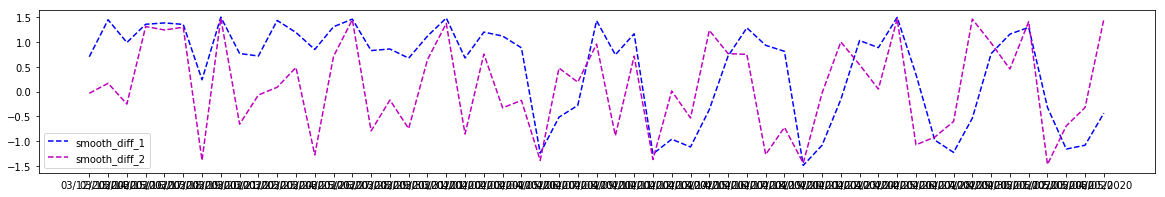

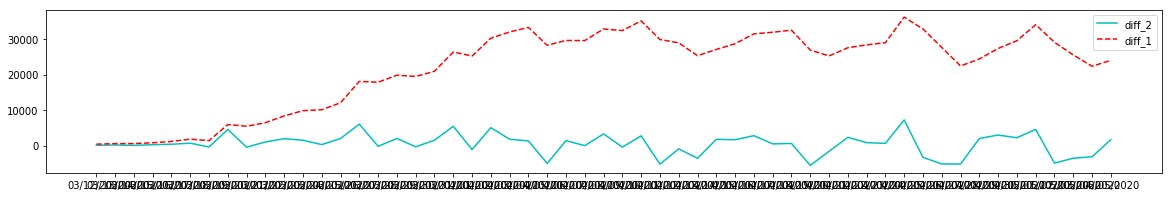

In [20]:
n_1 = 50

plt.figure(figsize =(20,3))
plt.plot(df_confirmed.index[n_1:], df_confirmed['smooth_diff_1'].values[n_1:], '--b', label='smooth_diff_1')
plt.plot(df_confirmed.index[n_1:], df_confirmed['smooth_diff_2'].values[n_1:], '--m', label='smooth_diff_2')
plt.legend()
plt.show()

plt.figure(figsize =(20,3))
plt.plot(df_confirmed.index[n_1:], df_confirmed['diff_2'].values[n_1:], '-c', label='diff_2')
plt.plot(df_confirmed.index[n_1:], df_confirmed['diff_1'].values[n_1:], '--r', label='diff_1')
plt.legend()
plt.show()

#plt.plot(df_deaths.index, df_deaths['Deaths'].values, 'r', label='Deaths')

In [21]:
def acf_pacf(feat):
    sm.graphics.tsa.plot_acf(df_confirmed[feat].values[n_1:], lags=30)
    sm.graphics.tsa.plot_pacf(df_confirmed[feat].values[n_1:], lags=30)
    plt.show()
    
def best_arima_result(feat, pdq, n_2=10):
    
    min_aic = np.inf
    best_param = (0, 0, 0)

    i = 0

    for param in pdq:

        try:
            model = ARIMA(df_confirmed[feat].values[n_1:-n_2], order=param)
            model_result = model.fit(disp=False)

            i +=1

            if model_result.aic < min_aic:
                min_aic = model_result.aic
                best_param = param
        except:
            continue

    print(f'Best ARIMA parameters: {best_param} with min AIC = {min_aic}')
    
    return best_param, min_aic

def predict_curve(feat, best_param, n_2=10):
    
    best_model = ARIMA(df_confirmed[feat].values[n_1:-n_2], order=best_param)
    results = best_model.fit()

    print(f'AIC: {results.aic}')

    pred_dynamic = results.forecast(n_2+10)[0]   

    plt.plot(pred_dynamic, '--b', label=f'predict {feat}')
    plt.plot(df_confirmed[feat].values[-n_2:], 'or', label=f'true {feat}')
    plt.title(f'Предсказание последних {n_2} точек исходного ряда {feat} + 10 точек после')
    plt.legend()

    plt.show()

In [22]:
ADF_diff_1 = sm.tsa.stattools.adfuller(df_confirmed['diff_1'].values[n_1:], regression='ctt')[1]
ADF_diff_2 = sm.tsa.stattools.adfuller(df_confirmed['diff_2'].values[n_1:], regression='ctt')[1]
ADF_smooth_diff_1 = sm.tsa.stattools.adfuller(df_confirmed['smooth_diff_1'].values[n_1:], regression='ctt')[1]
ADF_smooth_diff_2 = sm.tsa.stattools.adfuller(df_confirmed['smooth_diff_2'].values[n_1:], regression='ctt')[1]

print(f'p_value for diff_1 = {ADF_diff_1:.5f}\n'
      f'p_value for diff_2 = {ADF_diff_2:.5f}\n'
      f'p_value for smooth_diff_1 = {ADF_smooth_diff_1:.5f}\n'
      f'p_value for smooth_diff_2 = {ADF_smooth_diff_2:.5f}')

p_value for diff_1 = 0.13517
p_value for diff_2 = 0.74571
p_value for smooth_diff_1 = 0.57824
p_value for smooth_diff_2 = 0.00000


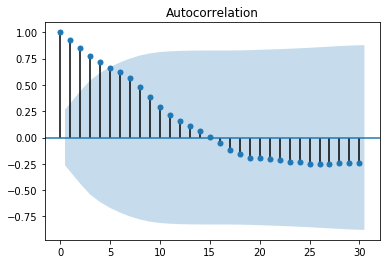

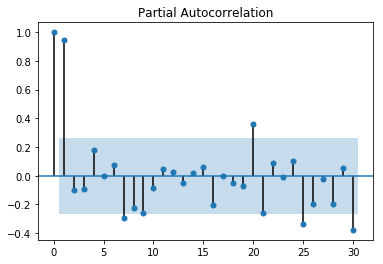

In [23]:
feat_1 = 'diff_1'
acf_pacf(feat_1)

In [24]:
q_1 = range(0, 5)
p_1 = [0, 1]
d_1 = [0, 1, 2]
pdq_1 = list(itertools.product(p_1, d_1, q_1))

best_1 = best_arima_result(feat_1, pdq_1, n_2=10)[0];

Best ARIMA parameters: (0, 2, 1) with min AIC = 810.9710404765018


AIC: 810.9710404765018


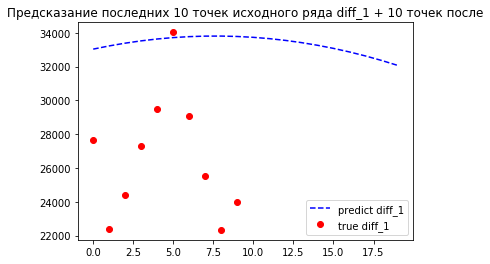

In [25]:
predict_curve(feat_1, best_1, n_2=10)

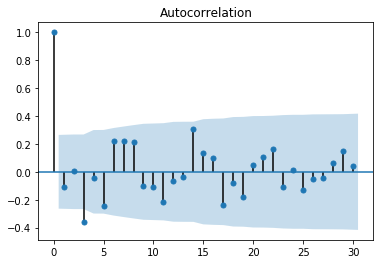

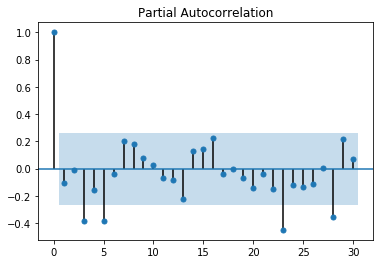

In [26]:
feat_2 = 'smooth_diff_2'
acf_pacf(feat_2)

In [27]:
q_2 = range(0, 4)
p_2 = [0, 3, 5, 23, 28]
d_2 = [0, 1, 2]
pdq_2 = list(itertools.product(p_2, d_2, q_2))

best_2 = best_arima_result(feat_2, pdq_2, n_2=10)[0];

Best ARIMA parameters: (5, 0, 0) with min AIC = 120.51791124819917


AIC: 120.51791124819917


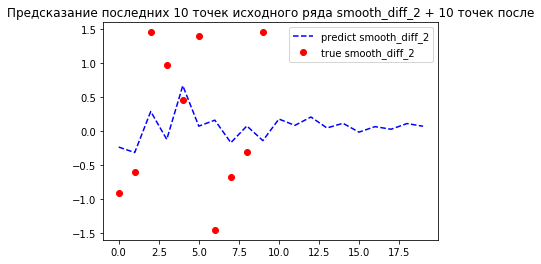

In [28]:
predict_curve(feat_2, best_2, n_2=10)

---------------------------------------------------------------------------------------------------------------

5) Оцените результат моделирования

Было проведено моделирование рядов 'diff_1' (первые разности) и 'smooth_diff_2'(разность между второй разностью и сглаженным рядом вторых разностей, нормированная на дисперсию сглаженного ряда вторых разностей).  
Тест стационарности рядов показал, что минимально значение ADF именно для данных рядов:  
ADF('diff_1') = 1e-1  
ADF('smooth_diff_2') = 1e-6  
Проведённое моделирование и предсказание по этим рядам показало min AIC('diff_1') = 810 и min AIC('smooth_diff_2') = 120, что ожидаемо, т.к. чем более стационарен ряд, тем лучше он должен моделироваться. Визуально можно оценить (см. графики), что предсказание для ряда 'smooth_diff_2' ближе к мат.ожиданию ряда.